# (30/100 points) For the CoppeliaSim Scene (workshop3.ttt1), use circles to represent the obstacles in the environment. The goal is located where the green sphere is

### Plot the representation of the environment using Python (matplotlib). Add the figure to your report.

Populating the interactive namespace from numpy and matplotlib


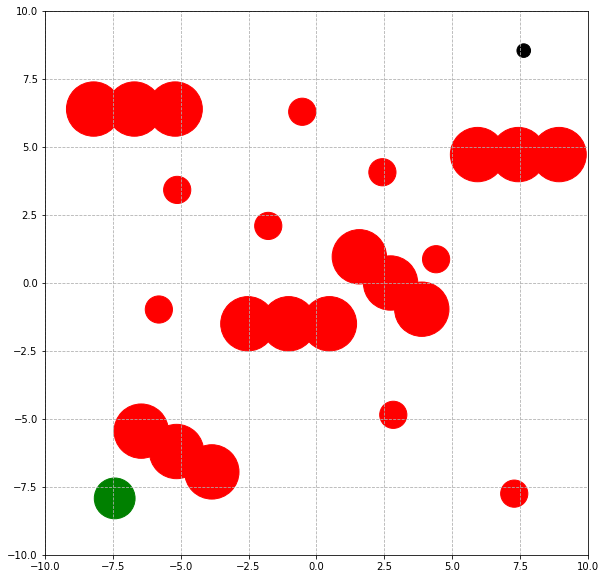

In [43]:
%pylab inline
import matplotlib.pyplot as plt
import math
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

plt.xlim(-10,10)
plt.ylim(-10,10)

plt.grid(linestyle='--')

ax.set_aspect(1)

# Circle Obstacles
avoid_circles = [[2.425, 4.075], [-0.525, 6.3], [4.4, 0.875], [-1.775, 2.1], [-5.125, 3.425], [-5.8, -0.975], [2.825, -4.85], [7.275, -7.75]]
for x, y in avoid_circles:
    ax.add_artist(plt.Circle((x, y), 0.5, color='r'))

# Wall obstacles
avoid_wall_circles = [[7.425, 4.725], [7.425 + 1.5, 4.725], [7.425 - 1.5, 4.725],
                     [-6.7, 6.4], [-6.7 + 1.5, 6.4], [-6.7 - 1.5, 6.4],
                     [-1.025, -1.5], [-1.025 + 1.5, -1.5], [-1.025 - 1.5, -1.5],
                     [2.725, 0], [2.725 - 1.5 * math.cos(2 * math.pi / 9), 1.5 * math.sin(2 * math.pi / 9)], [2.725 + 1.5 * math.cos(2 * math.pi / 9), -1.5 * math.sin(2 * math.pi / 9)],
                     [-5.15, -6.2], [-5.15 - 1.5 * math.cos(math.pi / 6), -6.2 + 1.5 * math.sin(math.pi / 6)], [-5.15 + 1.5 * math.cos(math.pi / 6), -6.2 - 1.5 * math.sin(math.pi / 6)]]
for x, y in avoid_wall_circles:
    ax.add_artist(plt.Circle((x, y), 1, color='r'))

    
# Goal
goal = [[-7.425, -7.925]]
for x, y in goal:
    ax.add_artist(plt.Circle((x, y), 0.75, color='g'))

# Starting point
ax.add_artist(plt.Circle((7.625, 8.55), 0.25, color='k'))
plt.show()

### Use Virtual Potential Fields to create a vector field that the robot can use to navigate towards the goal. Plot the vector field using Python (the function quiver can be useful) and add the plot to your report.

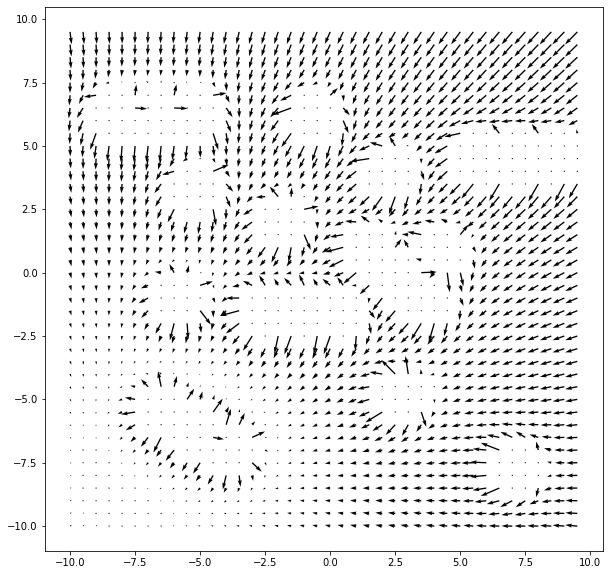

In [44]:
k = 1
repulsive_k = 20

X, Y = np.meshgrid(np.arange(-10, 10, 0.5), np.arange(-10, 10, 0.5))

@np.vectorize
def force(x_pos, y_pos):
    x_goal_pos = goal[0][0]
    y_goal_pos = goal[0][1]
    x_out = k * (x_goal_pos - x_pos)
    y_out = k * (y_goal_pos - y_pos)
    for x, y in avoid_circles:
        distance = math.sqrt((x - x_pos)**2 + (y - y_pos)**2)
        y_out += repulsive_k / (distance**3) * ((-y + y_pos) / distance)
        x_out += repulsive_k / (distance**3) * ((-x + x_pos) / distance)
    for x, y in avoid_wall_circles:
        distance = math.sqrt((x - x_pos)**2 + (y - y_pos)**2)
        y_out += repulsive_k / (distance**3) * ((-y + y_pos) / distance)
        x_out += repulsive_k / (distance**3) * ((-x + x_pos) / distance)
    return x_out, y_out

# So that the large forces from inside the obstacles don't overpower the rest of the field
@np.vectorize
def filter_large(x_force, y_force):
    if (x_force ** 2 + y_force ** 2 > 750):
        return 0, 0
    return x_force, y_force

U, V = force(X, Y)
U, V = filter_large(U, V)
fig1, ax1 = plt.subplots(figsize=(10,10))
Q = ax1.quiver(X, Y, U, V)


### Use the potential field to drive the robot towards the goal. Record a video of the robot following the potential field, upload it to youtube, vimeo, or googledrive, and add the link to your report.

In [45]:
import sim

class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if self.client_id != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return self.client_id
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)
            if (err_code != 0):
                print(f"ERROR SENDING MOTOR VELS {err_code}")
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(self.client_id, self.frame, relative_object, position, sim.simx_opmode_streaming)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

In [38]:
def vpf_nav():
    # Joint name in coppelia
    motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
    r = robot('Omnirob', motor_names)  # Create an instance of our robot

    x, y, _ = r.get_position()
    while (x-goal[0][0])**2 + (y-goal[0][1])**2 > 1.2:
        vx, vy = force(x, y)
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
        x, y, _ = r.get_position()
        
    r.send_motor_velocities([0, 0, 0, 0])
vpf_nav()

Robot connected
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1


# (30/100 points) Breadth First Search

### Discretize the environment using a grid (feel free to choose the size of the cells)

Populating the interactive namespace from numpy and matplotlib


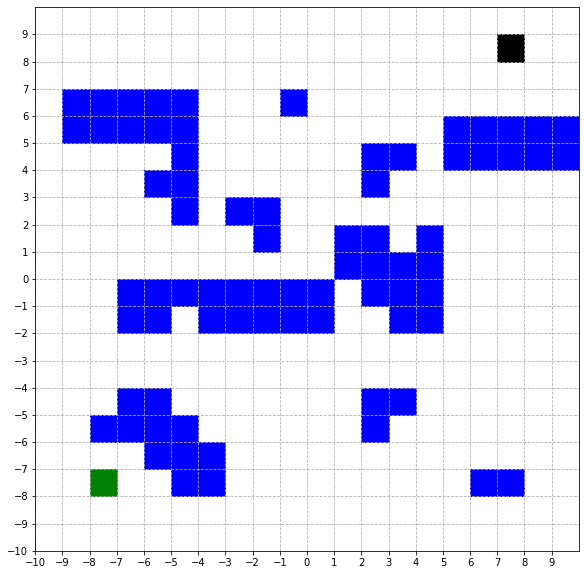

In [46]:
%pylab inline
import matplotlib.pyplot as plt
import math
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

plt.xlim(-10,10)
plt.ylim(-10,10)

plt.grid(linestyle='--')

ax.set_aspect(1)

# Circle Obstacles
cylindar_blocks = [[2, 4], [-5, 2], [2, 3], [-1, 6], [4, 1], [4, 0], [-2, 2], [-3, 2], [-2, 1], [-6, 3], [-5, 3], [-6, -1], [-6, -2], [-7, -1], [-7, -2], [3, -5], [2, -5], [2, -6], [7, -8], [6, -8], [3, 4], [-5, -1]]
for x, y in cylindar_blocks:
    ax.add_artist(plt.Rectangle((x, y), 1, 1, color='b'))

# Wall obstacles
wall_blocks = [[-8, -6], [-5, 4], [6, 4], [6, 5], [7, 4], [7, 5], [8, 4], [8, 5], [9, 4], [9, 5], [5, 4], [5, 5], [-8, 5], [-8, 6], [-7, 5], [-7, 6], [-6, 5], [-6, 6], [-5, 5], [-5, 6], [-9, 5], [-9, 6], [-2, -2], [-1, -2], [-0, -2], [-4, -2], [-3, -2], [-2, -1], [-1, -1], [-0, -1], [-4, -1], [-3, -1], [2, -1], [3, -1], [3, -0], [1, 0], [1, 1], [2, 0], [2, 1], [3, -2], [4, -2], [4, -1], [-6, -7], [-6, -6], [-5, -7], [-5, -6], [-7, -6], [-7, -5], [-6, -5], [-5, -8], [-4, -8], [-4, -7]]
for x, y in wall_blocks:
    ax.add_artist(plt.Rectangle((x, y), 1, 1, color='b'))

# Goal
goal = [-8, -8]
ax.add_artist(plt.Rectangle((goal[0], goal[1]), 1, 1, color='g'))

# Starting point
starting_point = [7, 8]
ax.add_artist(plt.Rectangle((starting_point[0], starting_point[1]), 1, 1, color='k'))

ax.set_xticks(numpy.arange(-10, 10, 1))
ax.set_yticks(numpy.arange(-10, 10., 1))

plt.show()

### Create a Graph where the cells without obstacles are the vertices, and adjacent cells are connected by edges.

In [47]:
def loc_to_index(x, y):
    return 19 - (y + 10),x + 10
def loc_arr_to_index(xy):
    return loc_to_index(xy[0], xy[1])
# This isn't a graph in the typical sense. The edges aren't explicitly stated, but rather implied by which cells entries are adjacent. 
# Zeros represent open area
graph = np.zeros((20, 20))
# Five represents obstacles
for x, y in cylindar_blocks:
    graph[loc_to_index(x, y)] = 5
for x, y in wall_blocks:
    graph[loc_to_index(x, y)] = 5
# Six represents goal
graph[loc_to_index(goal[0], goal[1])] = 6
print(graph)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 5. 5. 5. 5. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 5. 5. 5. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 5. 5. 5. 5.]
 [0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 5. 5. 0. 5. 5. 5. 5. 5.]
 [0. 0. 0. 0. 5. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 5. 0. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 5. 5. 0. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 5. 5. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 5. 5. 5. 5. 5. 5. 5. 0. 5. 5. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 5. 0. 5. 5. 5. 5. 5. 0. 0. 5. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 5. 5. 0. 0. 0. 0. 0. 0. 0. 5. 5. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 5. 5. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0.

### Use the Breadth First Search Algorithm to find a path that goes from the location of the robot to the goal. Plot the resultant path and add it to your report.

In [48]:
from copy import copy, deepcopy

def bfs(obstacle_graph, starting_point):
    # 9 Represents the starting point
    traversal_graph = deepcopy(obstacle_graph)
    traversal_graph[loc_arr_to_index(starting_point)] = 9
    queue = [starting_point]

    def add_vertex(x, y, parent):
        if (x <= 9 and x >= -10 and y <= 9 and y >= -10):
            if (traversal_graph[loc_to_index(x, y)] == 0):
                traversal_graph[loc_to_index(x, y)] = parent
                queue.append([x, y])
            elif (traversal_graph[loc_to_index(x, y)] == 6):
                # Traverse the path backwards to go back to the starting location
                while (parent != 9):
                    if parent == 1:
                        x -= 1
                    elif parent == 2:
                        y -= 1
                    elif parent == 3:
                        x += 1
                    elif parent == 4:
                        y += 1
                    parent = traversal_graph[loc_to_index(x, y)]
                    # 7 means that that vertex is on the final path
                    if (parent != 9):
                        traversal_graph[loc_to_index(x, y)] = 7
                return True
        return False

    while len(queue) > 0:
        x, y = queue.pop(0)
        # 1 means it traveled right to reach there
        # 2 means it traveled up to reach there
        # 3 means it traveled left to reach there
        # 4 means it traveled left to reach there
        if (add_vertex(x + 1, y, 1) or add_vertex(x, y + 1, 2) or add_vertex(x - 1, y, 3) or add_vertex(x, y - 1, 4)):
            break
    return traversal_graph

traversal_graph = bfs(graph, starting_point)
print(traversal_graph)

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2.]
 [3. 3. 3. 3. 3. 3. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 9. 1. 1.]
 [4. 4. 4. 4. 4. 4. 7. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 5. 5. 5. 5. 5. 7. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 5. 5. 5. 5. 5. 7. 4. 4. 3. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5.]
 [4. 1. 1. 1. 1. 5. 7. 4. 4. 4. 4. 4. 5. 5. 4. 5. 5. 5. 5. 5.]
 [4. 4. 4. 2. 5. 5. 7. 4. 4. 4. 4. 4. 5. 3. 4. 1. 1. 1. 1. 1.]
 [4. 4. 3. 3. 2. 5. 7. 5. 5. 4. 4. 4. 3. 4. 4. 4. 4. 4. 4. 4.]
 [4. 7. 7. 7. 7. 7. 7. 1. 5. 4. 4. 5. 5. 4. 5. 4. 4. 4. 4. 4.]
 [4. 7. 4. 4. 4. 4. 4. 3. 3. 4. 4. 5. 5. 5. 5. 4. 4. 4. 4. 4.]
 [4. 7. 4. 5. 5. 5. 5. 5. 5. 5. 5. 2. 5. 5. 5. 4. 4. 4. 4. 4.]
 [4. 7. 4. 5. 5. 2. 5. 5. 5. 5. 5. 3. 2. 5. 5. 4. 4. 4. 4. 4.]
 [4. 7. 4. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]
 [4. 7. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 7. 4. 5. 5. 4. 4. 4. 4. 4. 4. 4. 5. 5. 4. 4. 4. 4. 4. 4.]
 [4. 7. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 5. 3. 4. 4. 4. 4.

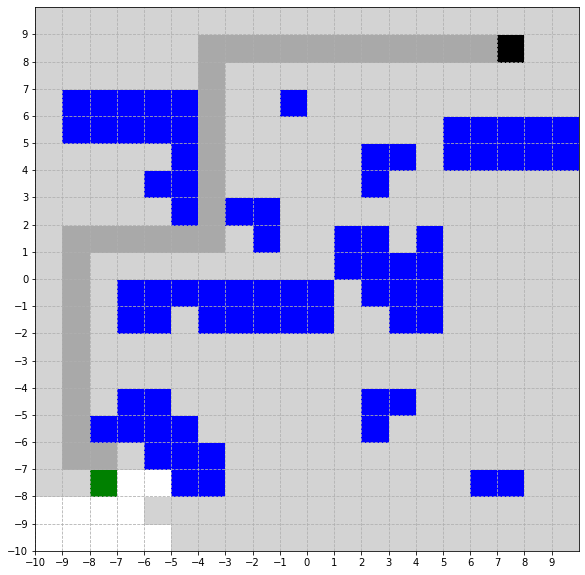

In [49]:
def graph_path(path_graph):
    fig1, ax1 = plt.subplots(figsize=(10, 10))

    plt.xlim(-10,10)
    plt.ylim(-10,10)

    plt.grid(linestyle='--')

    ax1.set_aspect(1)

    for y in range(-10, 10):
        for x in range(-10, 10):
            val = path_graph[loc_to_index(x, y)]
            if (val == 0):
                color = 'w'
            elif (val >= 1 and val <= 4):
                color = "lightgrey"
            elif (val == 5):
                color = 'b'
            elif (val == 6):
                color = 'g'
            elif (val == 7):
                color = "darkgrey"
            elif (val == 9):
                color = 'k'
            ax1.add_artist(plt.Rectangle((x, y), 1, 1, color=color))

    ax1.set_xticks(numpy.arange(-10, 10, 1))
    ax1.set_yticks(numpy.arange(-10, 10., 1))

    plt.show()
graph_path(traversal_graph)

### Covert the path to a trajectory (adding time to the waypoints), and use the robot to follow the trajectory. Record a video of the robot following the trajectory, upload it to youtube, vimeo, or googledrive, and add the link to your report.

In [50]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot
disk = robot('Disc', client_id=r.client_id)
starting_pos = r.get_position()
def traj(tf, desired_pos):
    global starting_pos
    start_time = sim.simxGetLastCmdTime(r.client_id)
    # Time interval
    time_step = 0.1
    time_steps = linspace(0, tf, round(tf / time_step))

    a1 = (desired_pos - starting_pos) / tf
    a0 = starting_pos

    for t in time_steps:
        point_traj = a1 * t + a0

        # Sensing
        robot_position = r.get_position()
        disk.set_position(point_traj)

        # Trajectory tracker
        u = 30 * (point_traj - robot_position)

        vx, vy, vz = u
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])

        if (sim.simxGetLastCmdTime(r.client_id) - start_time < (t + time_step) * 1000):
            time.sleep((t + time_step) - (sim.simxGetLastCmdTime(r.client_id) - start_time) / 1000)
        else:
            pass
#             print(f"BEHIND{sim.simxGetLastCmdTime(r.client_id) - start_time - (t + time_step)*1000}")
    starting_pos = desired_pos

traj(20, array([-3.5, 8.5, 0.1]))
traj(20, array([-3.5, 1.5, 0.1]))
traj(15, array([-8.5, 1.5, 0.1]))
traj(20, array([-8.5, -6.5, 0.1]))
traj(5, array([-7.5, -6.5, 0.1]))
traj(5, array([-7.5, -7.5, 0.1]))
r.send_motor_velocities([0, 0, 0, 0])


Robot connected
Robot connected
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1
ERROR SENDING MOTOR VELS 1


KeyboardInterrupt: 

# 3. (30/100 points) A*

### (a). Implement the A* algorithm using the Euclidean distance from the robot to the goal as the heuristic

In [51]:
from queue import PriorityQueue

def astar(obstacle_graph, starting_point):
    distances = np.zeros((20, 20))

    # 9 Represents the starting point
    a_traversal_graph = deepcopy(obstacle_graph)
    a_traversal_graph[loc_arr_to_index(starting_point)] = 9
    queue = PriorityQueue()
    
    path = []
    
    def add_to_queue(x, y, current_distance):
        min_remaining_distance = math.sqrt((x - goal[0]) ** 2 + (y - goal[1]) ** 2)
        # This is the manhattan distance version (which is likely faster since thats the way these robots travel)
        # min_remaining_distance = abs(x - goal[0]) + abs(y - goal[1])
        queue.put((current_distance + min_remaining_distance, [x, y]))
        
    def add_vertex(x, y, parent, current_dist):
        if (x <= 9 and x >= -10 and y <= 9 and y >= -10):
            if (a_traversal_graph[loc_to_index(x, y)] == 0):
                distances[loc_to_index(x, y)] = current_dist
                a_traversal_graph[loc_to_index(x, y)] = parent
                add_to_queue(x, y, current_dist)
            elif (a_traversal_graph[loc_to_index(x, y)] == 6):
                # Traverse the path backwards to go back to the starting location
                while (parent != 9):
                    path.append([x + 0.5, y + 0.5])
                    if parent == 1:
                        x -= 1
                    elif parent == 2:
                        y -= 1
                    elif parent == 3:
                        x += 1
                    elif parent == 4:
                        y += 1
                    parent = a_traversal_graph[loc_to_index(x, y)]
                    # 7 means that that vertex is on the final path
                    if (parent != 9):
                        a_traversal_graph[loc_to_index(x, y)] = 7
                return True
        return False
    
    add_to_queue(starting_point[0], starting_point[1], 0)
    while not queue.empty():
        _, coords = queue.get()
        x, y = coords
        distance = distances[loc_to_index(x, y)]
        distance += 1
        # 1 means it traveled right to reach there
        # 2 means it traveled up to reach there
        # 3 means it traveled left to reach there
        # 4 means it traveled left to reach there
        if (add_vertex(x + 1, y, 1, distance) or add_vertex(x, y + 1, 2, distance) 
            or add_vertex(x - 1, y, 3, distance) or add_vertex(x, y - 1, 4, distance)):
            break
    path.reverse()
    return a_traversal_graph, path

### (b). Test your implementation using the discretization of the previous algorithm. Then find a path that goes from the location of the robot to the goal. Plot the resultant path and add it to your report.

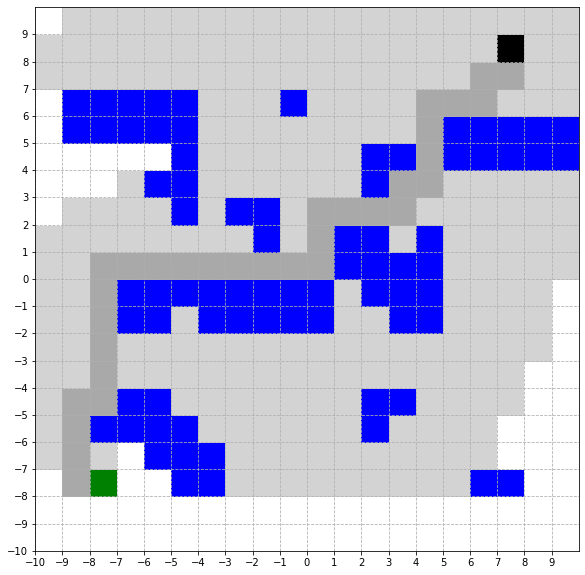

Path: [[7.5, 7.5], [6.5, 7.5], [6.5, 6.5], [5.5, 6.5], [4.5, 6.5], [4.5, 5.5], [4.5, 4.5], [4.5, 3.5], [3.5, 3.5], [3.5, 2.5], [2.5, 2.5], [1.5, 2.5], [0.5, 2.5], [0.5, 1.5], [0.5, 0.5], [-0.5, 0.5], [-1.5, 0.5], [-2.5, 0.5], [-3.5, 0.5], [-4.5, 0.5], [-5.5, 0.5], [-6.5, 0.5], [-7.5, 0.5], [-7.5, -0.5], [-7.5, -1.5], [-7.5, -2.5], [-7.5, -3.5], [-7.5, -4.5], [-8.5, -4.5], [-8.5, -5.5], [-8.5, -6.5], [-8.5, -7.5], [-7.5, -7.5]]


In [52]:
traversal_graph, path = astar(graph, starting_point)
graph_path(traversal_graph)
print(f"Path: {path}")

### (c). Covert the path to a trajectory (adding time to the waypoints), and use the robot to follow the trajectory. Record a video of the robot following the trajectory, upload it to youtube, vimeo, or googledrive, and add the link to your report

In [53]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot
# disk = robot('Disc', client_id=r.client_id)
starting_pos = r.get_position()
def traj(tf, desired_pos):
    global starting_pos
    start_time = sim.simxGetLastCmdTime(r.client_id)
    # Time interval
    time_step = 0.05
    time_steps = linspace(0, tf, round(tf / time_step))

    a1 = (desired_pos - starting_pos) / tf
    a0 = starting_pos

    for t in time_steps:
        point_traj = a1 * t + a0

        # Sensing
        robot_position = r.get_position()
#         disk.set_position(point_traj)

        # Trajectory tracker
        u = 40 * (point_traj - robot_position)

        vx, vy, vz = u
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])

        if (sim.simxGetLastCmdTime(r.client_id) - start_time < (t + time_step) * 1000):
            time.sleep((t + time_step) - (sim.simxGetLastCmdTime(r.client_id) - start_time) / 1000)
        else:
            pass
#             print(f"BEHIND{sim.simxGetLastCmdTime(r.client_id) - start_time - (t + time_step)*1000}")
    starting_pos = desired_pos

for x, y in path:
    traj(2, array([x, y, 0.1]))
r.send_motor_velocities([0, 0, 0, 0])

Connection failed
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64
ERROR SENDING MOTOR VELS 64


KeyboardInterrupt: 

# 4. (10/100 points) Compare

### (a). Move the robot to the location (7.1,-8.6, 0.0)

### (b). What happens when you run the virtual potential function method?

In [31]:
vpf_nav()

Robot connected


TypeError: 'int' object is not subscriptable

### (c). Plot the paths for the BFS and the A* algorithm. Do they differ?

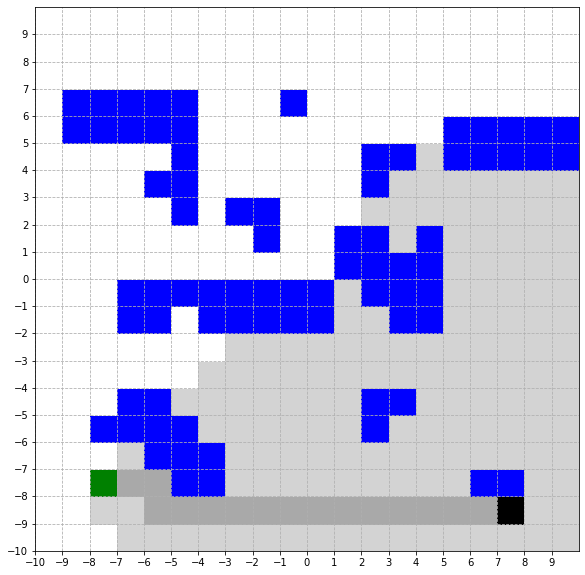

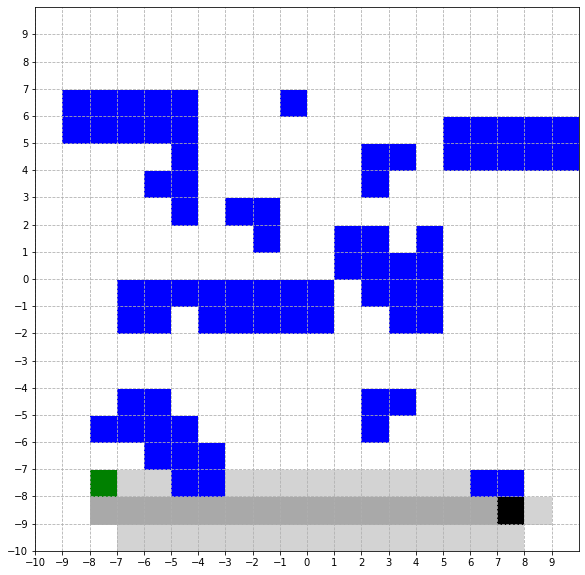

In [54]:
traversal_graph = bfs(graph, array([7, -9]))
graph_path(traversal_graph)

traversal_graph, path = astar(graph, array([7, -9]))
graph_path(traversal_graph)